# Load the Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
fn = '/content/drive/MyDrive/DataSets/tripadvisor_hotel_reviews.csv'
df = pd.read_csv(fn)
df.head(5)

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


# Preprocessing the Data

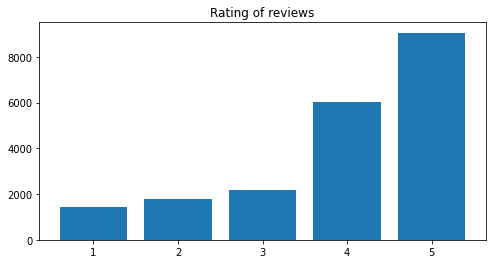

In [ ]:
plot = df['Rating'].value_counts()
x, y = plot.index[0:], plot[0:]

fig, ax = plt.subplots()
ax.bar(x, y)
ax.set(title='Rating of reviews')
fig.set_figwidth(8)
plt.show()

In [ ]:
df = df[df['Rating']!=3]

In [ ]:
df['Sentiment'] = np.where(df.Rating > 3, 1, 0)

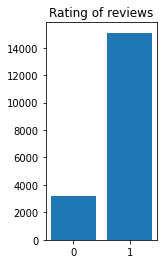

In [ ]:
plot = df['Sentiment'].value_counts()
x, y = plot.index[0:], plot[0:]

fig, ax = plt.subplots()
ax.bar(x, y)
ax.set(title='Rating of reviews')
fig.set_figwidth(2)
plt.show()

In [ ]:
X = df['Review'].copy()
y = df['Sentiment'].copy()

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    X.values.tolist(), y, test_size= 0.2, random_state=42)

In [ ]:
!pip install -U transformers

In [ ]:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

seq_len = 350

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=seq_len)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=seq_len)

input_ids_train = np.array(train_encodings['input_ids']) 
attention_mask_train = np.array(train_encodings['attention_mask'])

input_ids_test = np.array(test_encodings['input_ids']) 
attention_mask_test = np.array(test_encodings['attention_mask'])

In [ ]:
# Example
exp_sen = 1

print("\nExample:\n")
print("Sentence:\n{}".format(train_texts[exp_sen]))
print("\nAfter tokenizing :\n{}".format(tokenizer.encode(train_texts[exp_sen])))
print("\nAfter padding :\n{}".format(input_ids_train[exp_sen]))


Example:

Sentence:
no1 boutique hotel london start finish hotel pleasure stay, arrival took lift check desk met friendly warm staff.our room upgraded free charge split level suite ready arrived, pass time afternoon tea lounge place accompanied couple glasses champagne.once ready shown room wow factor possible luxury, room clean plenty space including massive bed ensuite bathroom showers.in lounge bar range complimentary drinks snacks help honesty wanted stronger.all great stay feel home home definately new year celerbrate,  

After tokenizing :
[101, 2053, 2487, 24611, 3309, 2414, 2707, 3926, 3309, 5165, 2994, 1010, 5508, 2165, 6336, 4638, 4624, 2777, 5379, 4010, 3095, 1012, 2256, 2282, 9725, 2489, 3715, 3975, 2504, 7621, 3201, 3369, 1010, 3413, 2051, 5027, 5572, 11549, 2173, 5642, 3232, 7877, 12327, 1012, 2320, 3201, 3491, 2282, 10166, 5387, 2825, 9542, 1010, 2282, 4550, 7564, 2686, 2164, 5294, 2793, 4372, 28880, 2063, 5723, 23442, 1012, 1999, 11549, 3347, 2846, 19394, 5649, 8974, 2

# Creating model

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.optimizers import Adam

In [ ]:
from transformers import TFDistilBertModel

bert = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
# Creating bert model
inp_ids = L.Input(shape=(seq_len,), dtype=tf.int32) # Shape:(batch_size, seq_len)
attention_mask = L.Input(shape=(seq_len,), dtype=tf.int32) # Shape:(batch_size, seq_len)
last_hidden_state = bert(inp_ids,attention_mask=attention_mask)[0] # Shape:(batch_size, seq_len, 768)
out = last_hidden_state[:,0,:] # Shape:(Batch_size, 768)

bert_model = tf.keras.Model(inputs=[inp_ids, attention_mask], outputs=out)

# Passing data from bert pretrained model and extracting the final state.

print("Passing train data")
bert_output_train = bert_model.predict(
    [input_ids_train,attention_mask_train], batch_size=16, verbose=1)

print("Passing test data")
bert_output_test = bert_model.predict(
    [input_ids_test,attention_mask_test], batch_size=16, verbose=1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [ ]:
print("Bert output train: {}".format(bert_output_train.shape))
print("Bert output test: {}".format(bert_output_test.shape))

Bert output train: (14645, 768)
Bert output test: (3662, 768)


In [ ]:
from tensorflow.python.keras.layers.core import Dense
import random as rn

seed_value = 1337
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
rn.seed(seed_value)

model = tf.keras.Sequential([
    L.Input(shape=(768)),
    L.Dense(128,activation='relu'),
    L.Dropout(0.3),
    L.Dense(256,activation='relu'),
    L.Dense(256,activation='relu'),
    L.Dropout(0.3),
    L.Dense(512,activation='relu'),
    L.Dropout(0.3),
    L.Dense(1, activation='relu')
])


model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',metrics=tf.metrics.BinaryAccuracy()
             )

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               98432     
_________________________________________________________________
dropout_23 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_24 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_25 (Dropout)         (None, 512)              

## Training model

In [ ]:
# Passing bert output for training
history = model.fit(
    bert_output_train, train_labels, epochs=20, validation_split=0.3, batch_size=32, verbose=1)

Epoch 1/20
321/321 [==============================] - 3s 6ms/step - loss: 0.2688 - binary_accuracy: 0.9003 - val_loss: 0.2476 - val_binary_accuracy: 0.9351
Epoch 2/20
321/321 [==============================] - 2s 5ms/step - loss: 0.2272 - binary_accuracy: 0.9269 - val_loss: 0.2194 - val_binary_accuracy: 0.9388
Epoch 3/20
321/321 [==============================] - 2s 5ms/step - loss: 0.2218 - binary_accuracy: 0.9314 - val_loss: 0.2259 - val_binary_accuracy: 0.9224
Epoch 4/20
321/321 [==============================] - 2s 5ms/step - loss: 0.2209 - binary_accuracy: 0.9278 - val_loss: 0.2203 - val_binary_accuracy: 0.9424
Epoch 5/20
321/321 [==============================] - 2s 5ms/step - loss: 0.2167 - binary_accuracy: 0.9318 - val_loss: 0.2445 - val_binary_accuracy: 0.8921
Epoch 6/20
321/321 [==============================] - 2s 5ms/step - loss: 0.2166 - binary_accuracy: 0.9324 - val_loss: 0.2221 - val_binary_accuracy: 0.9290
Epoch 7/20
321/321 [==============================] - 2s 6ms/ste

## Training history

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


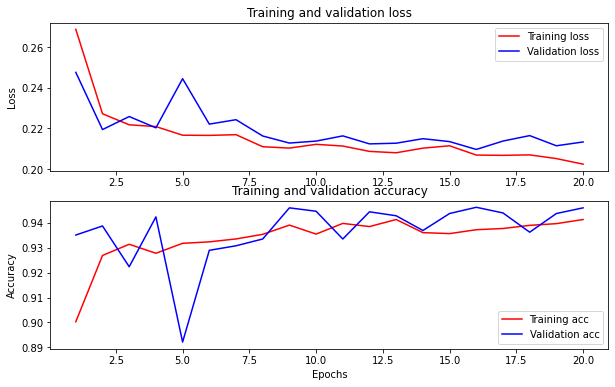

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Evaluate model

In [ ]:
pred = (model.predict(bert_output_test) > 0.5).astype("int32")

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [ ]:
print('Accuracy: {}'.format(accuracy_score(pred, test_labels)))
print('F1 Score: {}'.format(f1_score(pred, test_labels)))
print('Recall: {}'.format(recall_score(pred, test_labels)))
print('Precision: {}'.format(precision_score(pred, test_labels)))

Accuracy: 0.9445658110322228
F1 Score: 0.9664185277088504
Recall: 0.960539296284117
Precision: 0.9723701731025299


# Save model

In [ ]:
dataset_name = 'trip_advisor_hotel_reviews'
saved_model_path = '/content/drive/MyDrive/{}_bert'.format(dataset_name)

model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/trip_advisor_hotel_reviews_bert/assets
